#Comp 767 Assignment 2 Question 4
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
Link: https://colab.research.google.com/drive/1nglpFgQybCWIzWmV7qMIbftXNXDsi4C6

In [125]:
#Assignment general instructions ask for runtimes in google colab
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.88 s


In [126]:
#imports
import gym

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

time: 3.25 ms


In [165]:
class mountain_car(object):

     #initialize parameters for mountain car
    def __init__(self,alpha,Lambda,seed):
        #set random seed
        np.random.seed(seed)
        #alpha parameter
        self.alpha = alpha
        #lambda parameter
        self.Lambda = Lambda
        #discount factor
        self.gamma = 1

        #number of tilings
        self.num_tilings = 8
        #deltas - each tile 1/8th of the bounded distance in each dimension
        self.delta_x = (0.5 - (-1.2))/self.num_tilings
        self.delta_v = (0.07 - (-0.07))/self.num_tilings

        #asymmetric offsets
        #textbook suggests for 2d environments to scale using vector (1,3)
        #x offsets are computed normally with no scaling
        self.offsets_x = -np.linspace(0,self.delta_x,self.num_tilings,endpoint=False) + (-1.2)
        #v offsets are computed normally and scaled by a factor of 3
        self.offsets_v = -np.multiply(np.linspace(0,self.delta_v,self.num_tilings,endpoint=False),3) + (-0.07)

    #compute state action value
    #sum of weights with non zero values in feature vector
    #here we just directly provide the indexes of the non zero values in feature vector
    #saves a lot of time over computing full dot product!
    def compute_q(self,w,indexes):
        q = 0
        for i in indexes:
            q += w[i]
        return q

    #convert current state to feature vector (indexes of feature vector)
    def state_to_indexes(self,s_t,a_t):
        indexes = []
        #get position and velocity
        x_t = s_t[0]
        v_t = s_t[1]

        #solve for indexes in each tiling based on position and velocity
        tile_x = np.floor(np.divide(np.subtract(x_t,self.offsets_x),self.delta_x)).astype(int)
        tile_v = np.floor(np.divide(np.subtract(v_t,self.offsets_v),self.delta_v)).astype(int)

        #create list of tuples with indexes
        #we do not create an explicit feature vector because it would be so sparse
        #we only need to know the indexes of the non zero elements
        for i in range(len(tile_x)):
            indexes.append((tile_x[i], tile_v[i], i, a_t))
            
        #return a list of tuples containing indexes of feature vector
        return indexes 

    #policy
    #epsilon-greedy when testing = false
    #greedy when testing = true
    def policy(self, state, w, testing, epsilon=0.1, num_actions = 3):
        #best state action value
        q_max = float('-inf')
        #best action according to state action values
        best_action = 0
        #generate permutation of 0,1,2 so we evaluate actions in a different order each time
        #reduces bias at the beggining of training
        actions = np.random.permutation(num_actions)

        #loop through actions
        for a in actions:
            #get indexes of feature vector for state
            indexes = self.state_to_indexes(state,a)
            #compute state action value
            q_i = self.compute_q(w,indexes)
            #check if action is best and update accordingly
            if q_i > q_max:
                q_max = q_i
                best_action = a
        
        #if we are testing just return best action (greedy)
        if testing:
            return best_action

        #if we are training, return action according to epsilon greedy policy
        #every action has a 1/epsilon chance
        action_distribution = np.ones(num_actions, dtype=float) * epsilon / num_actions
        #update probability of best action to increase its chance by (1-epsilon)
        action_distribution[best_action] += (1.0 - epsilon)

        #pick and return action according to distribution
        action = np.random.choice(np.arange(num_actions), p = action_distribution)
        return action

    #run sarsa_lambda on env
    def sarsa_lambda(self,env,seed):
        #set random seed for gym environment
        env.seed(seed)

        #initialize weights
        #need a weight for every q(s,a)
        #number of possible tiles for x values is 9
        #number of possible tiles for v values is 11 (larger because of asymmetric offsets)
        w = np.zeros([9,11,self.num_tilings,3])

        #store the steps on each of the first 50 episodes
        steps_data = np.zeros(50)

        #train for max 1000 episodes
        for episode in range(100):
            #reset environment
            state = env.reset()
            #choose action according to epsilon greedy policy
            action = self.policy(state,w,False)
            #initialize z vector (replacing traces)
            z = np.zeros([9,11,self.num_tilings,3])
            #Boolean for finishing task
            done = False
            #number of steps in episode
            steps = 0

            while not done:
                #take action 
                next_state, reward, done, _ = env.step(action)
                #set delta
                delta = reward
                #get indexes of feature vector for state
                indexes = self.state_to_indexes(state,action)
                #iterate through indexes
                for i in indexes:
                    #update delta
                    delta -= w[i]
                    #replacing traces computation
                    z[i] = 1

                #If we have reached a terminal state, update weight, move to next episode
                if done:
                    w = w + (self.alpha * delta * z)
                #if we have not reached a terminal state
                else:
                    #get our next action from next_state
                    next_action = self.policy(next_state,w,False)
                    #get indexes of feature vector for next_state 
                    indexes = self.state_to_indexes(next_state,next_action)
                    ##iterate through indexes
                    for i in indexes:
                        #update delta
                        delta += (self.gamma * w[i])
                    #update weights
                    w = w + (self.alpha * delta * z)
                    #update trace values
                    z = (self.gamma * self.Lambda * z)

                    #propogate state and action values
                    state = next_state
                    action = next_action
                    #count steps
                    steps += 1

            #add number of steps in finished episode to array
            if episode < 50:
                steps_data[episode] = steps

        #return training and testing data
        return [self.play_game(env,w),np.mean(steps_data)]

    #play game for testing
    #run this after training is done
    def play_game(self,env,w):
        #count our steps
        steps = 0
        #reset our environment
        state = env.reset()
        #termination boolean
        done = False
        #while task is not done
        while not done:
            #get action - greedy policy
            action = self.policy(state,w,True)
            #step through env
            next_state, reward, done, _ = env.step(action)
            #count steps
            steps+=1
            #update state
            state = next_state
        #return number of steps
        return steps


time: 254 ms


#Mountain Car Experiment
For our experiment we implemented SARSA($\lambda$) with replacing traces and asymmetric tile coding. We tested SARSA($\lambda$) on the Mountain car environment. We tested SARSA($\lambda$) across multiple $\alpha$ and $\lambda$ values to examine how performane varied with different parameter combinations. For each pair of $\alpha$ and $\lambda$ values, SARSA($\lambda$) was trained for 200 episodes with an $\epsilon$-greedy policy ($\epsilon$ = 0.1) before testing. This process was repeated across 20 different random seeds for each pair of $\alpha$ and $\lambda$ values. The results of our experiment are below.

###Environment
The mountain car environment is a scenario in which an under-powered car must drive up a steep hill, by learning to leverage potential energy by driving up the opposite hill before climbing the target hill. There are three actions, full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The reward in this problem is -1 on all time steps until the car moves past its goal
position at the top of the mountain, which ends the episode. The
car moves according to simplified physics equations and has bounded position and velocity. 



In [169]:
 #select environment
 env = gym.make('MountainCar-v0')
 #change number of default steps
 env._max_episode_steps = 2000

time: 6.05 ms


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [182]:
#random seeds
seeds = np.arange(0,20)
#alpha values
alpha = np.array([0.1,0.3,0.5,0.7,0.9,1.1])
#scale alpha values proportionally to number of tilings
#here we will scale to exactly the number of tilings (10)
#this is discussed on page 217-218 of Sutton and Barto textbook
alpha = np.divide(alpha,16)
#lambda values
Lambda = [0.0,0.5,0.95]

avg = np.zeros([len(Lambda),len(alpha)])
std = np.zeros([len(Lambda),len(alpha)])
avg_50_steps = np.zeros([len(Lambda),len(alpha)])
std_50_steps = np.zeros([len(Lambda),len(alpha)])

#loop through parameter pairs
for i in range(len(Lambda)):
    for j in range(len(alpha)):
        print(alpha[j],'and',Lambda[i])
        #arrays for statistics
        RSME_stats = np.zeros(len(seeds))
        avg_steps_stats = np.zeros(len(seeds))
        #do k indepedent runs
        for k in range(len(seeds)):
            #create the mountain car
            car = mountain_car(alpha[j],Lambda[i],seeds[k])
            #train sarsa lambda
            data = car.sarsa_lambda(env,int(seeds[k]))
            #collect statistics
            RSME_stats[k] = data[0]
            avg_steps_stats[k] = data[1]

        #compute mean and standard deviation statistics for parameter pair
        avg[i,j] = np.mean(RSME_stats)
        std[i,j] = np.std(RSME_stats)
        avg_50_steps[i,j] = np.mean(avg_steps_stats)
        std_50_steps[i,j] = np.std(avg_steps_stats)

0.00625 and 0.0
0.01875 and 0.0
0.03125 and 0.0
0.04375 and 0.0
0.05625 and 0.0
0.06875 and 0.0
0.00625 and 0.5
0.01875 and 0.5
0.03125 and 0.5
0.04375 and 0.5
0.05625 and 0.5
0.06875 and 0.5
0.00625 and 0.95
0.01875 and 0.95
0.03125 and 0.95
0.04375 and 0.95
0.05625 and 0.95
0.06875 and 0.95
time: 44min


#Data

In [190]:
#print average
print(avg)
#print standard deviations
print(std)
#print(avg_50_steps)
#print(std_50_steps)

[[ 857.05  267.7   152.35  147.2   146.45  151.75]
 [1142.    258.45  135.15  137.6   127.55  144.55]
 [ 217.1   106.    126.85  218.9   224.3   226.05]]
[[839.55872189 398.54837849  35.03037967  22.51577225  19.55626498
   17.07593336]
 [862.89396799 401.75757305  26.42210249  28.95064766  25.100747
   24.35872534]
 [410.36104835  15.15255754  58.39458451 409.51323544 407.92721164
  407.8816587 ]]
time: 4.7 ms


In [181]:
#compute best result (according to average steps per episode)
i,j = np.unravel_index(avg.argmin(), avg.shape)
print("Best result")
print('\u03BB = ', Lambda[i])
print('\u03B1 = ', alpha[j])
print('Steps = ',avg[i,j])
print('std = ', std[i,j])

Best result
λ =  0.95
α =  0.01875
Steps =  106.0
std =  15.152557539900648
time: 7 ms


#Discussion
SARSA(0.95) had the best average performance on the mountain car task (after training) for low $\alpha$ values, performing significantly better than SARSA(0) and SARSA(0.5). SARSA(0.95) also achieved the lowest average steps per episode and lowest standard deviation across the entire experiment with $\alpha$ = 0.3/16. However when $\alpha$ > 0.5/16, SARSA(0.95) performed worse on average and also had a significantly higher standard deviation across indepedent runs than SARSA(0) and SARSA(0.5). SARSA(0) and SARSA(0.5) performed very similarily to each other, with poor performance (high average steps per episode and high standard deviation) when $\alpha$ < 0.5/16. However for $\alpha$ >= 0.5/16, SARSA(0) and SARSA(0.5) perform well, with both a low average steps per episode and very low variance across runs.

Our results show that with SARSA($\lambda$) on the mountain car environment, to achieve optimal performance a higher $\lambda$ is a good idea, this may be due to the fact that even very successful runs can take more than 100 steps and therefore larger $\lambda$ values do a better job propogating results back to previous states with the trace. An important observation that we made though is that it is cruical to find an appropriate $\alpha$ value for high $\lambda$ values otherwise your agent may be subject to high variance performance. In general lower $\lambda$ values seem to have low variance for a wider range of $\alpha$ values.

The third graph below shows that SARSA(0.95) trains much faster than SARSA(0.5) and SARSA(0) over the first 50 episodes. Based on the testing results, eventually for some values of $\alpha$, SARSA(0.5) and SARSA(0) are able to catch up and even surpass SARSA(0.95) in terms of average performance and variation across independent runs.

Implementation notes: Only trained for 200 episodes because that was sufficient to achieve good results, and saved a good amount of time in the full experiment runtime. Used a reduced set of $\lambda$ values to make runtime of experiment more reasonable, but tried to pick a wide range of $\lambda$ values to enable an interesting and informative analysis.

1st Graph: Full experimental results

2nd Graph: Full experimental results, zoomed in 

3rd Graph: Replica of graph on page 306 of Sutton and Barto textbook (analysis of early training results)

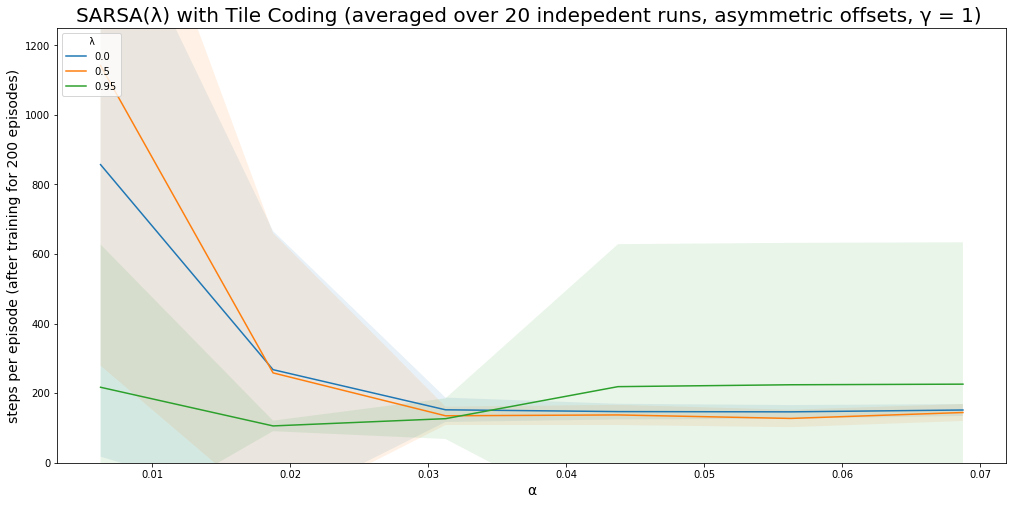

time: 372 ms


In [191]:
plt.figure(figsize=(17,8))
plt.ylim(0,1250)

for i in range(len(Lambda)):
    plt.plot(alpha,avg[i,:],label=Lambda[i])
    plt.fill_between(alpha,avg[i,:]-std[i,:],avg[i,:]+std[i,:],alpha=0.1)
    

plt.title('SARSA(\u03BB) with Tile Coding (averaged over 20 indepedent runs, asymmetric offsets, \u03B3 = 1) ', fontsize=20)
plt.xlabel('\u03B1',fontsize=14)
plt.ylabel('steps per episode (after training for 200 episodes)',fontsize=14)
plt.legend(loc='upper left',title='\u03BB')
plt.show()

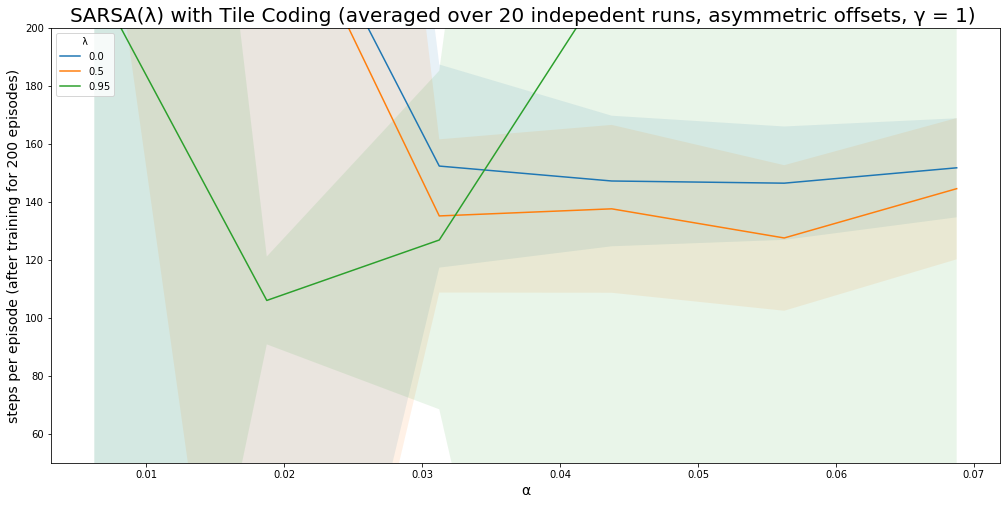

time: 429 ms


In [192]:
plt.figure(figsize=(17,8))
plt.ylim(50,200)

for i in range(len(Lambda)):
    plt.plot(alpha,avg[i,:],label=Lambda[i])
    plt.fill_between(alpha,avg[i,:]-std[i,:],avg[i,:]+std[i,:],alpha=0.1)
    

plt.title('SARSA(\u03BB) with Tile Coding (averaged over 20 indepedent runs, asymmetric offsets, \u03B3 = 1) ', fontsize=20)
plt.xlabel('\u03B1',fontsize=14)
plt.ylabel('steps per episode (after training for 200 episodes)',fontsize=14)
plt.legend(loc='upper left',title='\u03BB')
plt.show()


---



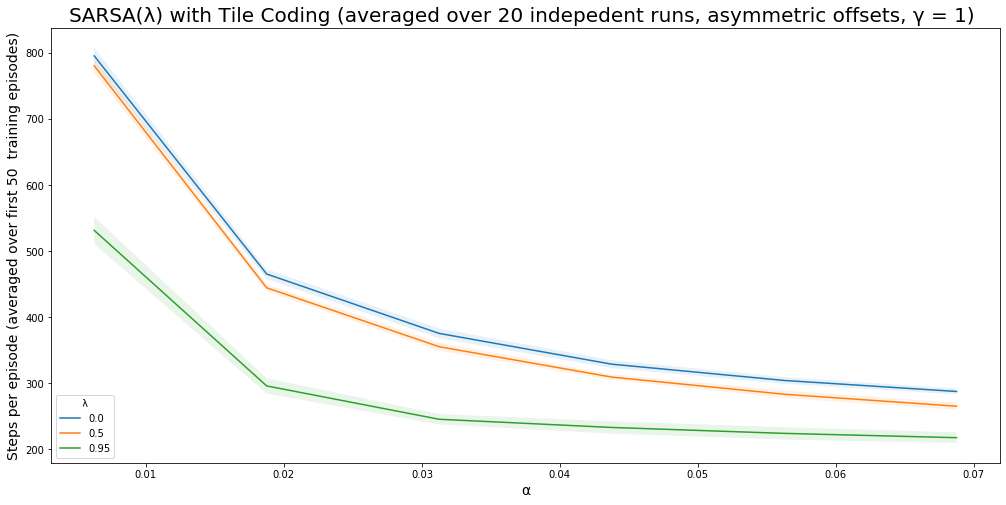

time: 372 ms


In [194]:
plt.figure(figsize=(17,8))
#plt.ylim(80,150)

for i in range(len(Lambda)):
    plt.plot(alpha,avg_50_steps[i,:],label=Lambda[i])
    plt.fill_between(alpha,avg_50_steps[i,:]-std_50_steps[i,:],avg_50_steps[i,:]+std_50_steps[i,:],alpha=0.1)
    

plt.title('SARSA(\u03BB) with Tile Coding (averaged over 20 indepedent runs, asymmetric offsets, \u03B3 = 1) ', fontsize=20)
plt.xlabel('\u03B1',fontsize=14)
plt.ylabel('Steps per episode (averaged over first 50  training episodes)',fontsize=14)
plt.legend(loc='lower left',title='\u03BB')
plt.show()

In [0]:
#experiment data backup

[[ 857.05  267.7   152.35  147.2   146.45  151.75]
 [1142.    258.45  135.15  137.6   127.55  144.55]
 [ 217.1   106.    126.85  218.9   224.3   226.05]]
[[839.55872189 398.54837849  35.03037967  22.51577225  19.55626498
   17.07593336]
 [862.89396799 401.75757305  26.42210249  28.95064766  25.100747
   24.35872534]
 [410.36104835  15.15255754  58.39458451 409.51323544 407.92721164
  407.8816587 ]]
[[795.933 465.58  375.669 329.08  304.428 287.706]
 [780.924 444.725 355.517 309.539 283.552 265.395]
 [531.726 296.136 245.639 233.244 224.27  217.747]]
[[12.36182394  7.29402495  7.3655807   5.99077624  5.11986875  4.45733598]
 [10.72294474  5.12715857  6.24751238  4.34860196  5.77452821  5.45329946]
 [20.72891806 11.55948892  7.93789512  9.29301157  9.33752323  8.10872931]]
time: 12.8 ms